In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

#loading relevant datasets from folder
drivers = pd.read_csv('drivers.csv')
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')

In [319]:
# Merges the drivers and races to the results
df = results.merge(drivers, on = "driverId").merge(races, on = "raceId")

In [320]:
# Converts dob and date to date times and calculates the age at time of the race
df["dob"] = pd.to_datetime(df["dob"])
df["date"] = pd.to_datetime(df["date"])
df["age"] = (df["date"] - df["dob"]).dt.days / 365

In [321]:
# Converts finsihing positions to ints as some might be a DNF (did not finish)
df["position"] = pd.to_numeric(df["position"], errors = "coerce")
df = df.dropna(subset = ["position"])

In [322]:
# Converts the laps completed to ints (some will be \\N because they did not finish) Then calculate laps compelted
df["laps_completed"] = pd.to_numeric(df["laps"], errors = "coerce")
df["total_laps"] = df.groupby("raceId")["laps"].transform("max") # Total laps in a race week
df["pct_laps_comp"] = (df["laps_completed"] / df["total_laps"]) * 100 # Gets percentage of laps done

In [323]:
# Converts to int for the grid positions (used to get pole positions) and excludes \\N for no times
df["grid"] = pd.to_numeric(df["grid"], errors = "coerce")

In [324]:
# Creating data set with variables used
comp_df = df[["driverId", "raceId", "age", "position", "pct_laps_comp", "points", "grid"]]
comp_df.to_csv("f1_driver_results.csv")

In [325]:
# Splits data into age groups
comp_df["age_group"] = pd.cut(comp_df["age"], bins = [18, 25, 30, 35, 40, 45, 50], 
                                              labels=["18-25", "25-30", "30-35", "35-40", "40-45", "45-50"])
avg_pos = comp_df.groupby("age_group")["position"].mean()
print("Average finishing position by age group:\n", avg_pos)

Average finishing position by age group:
 age_group
18-25    9.581542
25-30    8.052687
30-35    7.225857
35-40    7.435000
40-45    8.056277
45-50    6.654867
Name: position, dtype: float64


C:\Users\Mands\AppData\Local\Temp\ipykernel_81980\2293354790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df["age_group"] = pd.cut(comp_df["age"], bins = [18, 25, 30, 35, 40, 45, 50],
C:\Users\Mands\AppData\Local\Temp\ipykernel_81980\2293354790.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pos = comp_df.groupby("age_group")["position"].mean()


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'position'}>],
       [<Axes: title={'center': 'pct_laps_comp'}>,
        <Axes: title={'center': 'points'}>],
       [<Axes: title={'center': 'grid'}>, <Axes: >]], dtype=object)

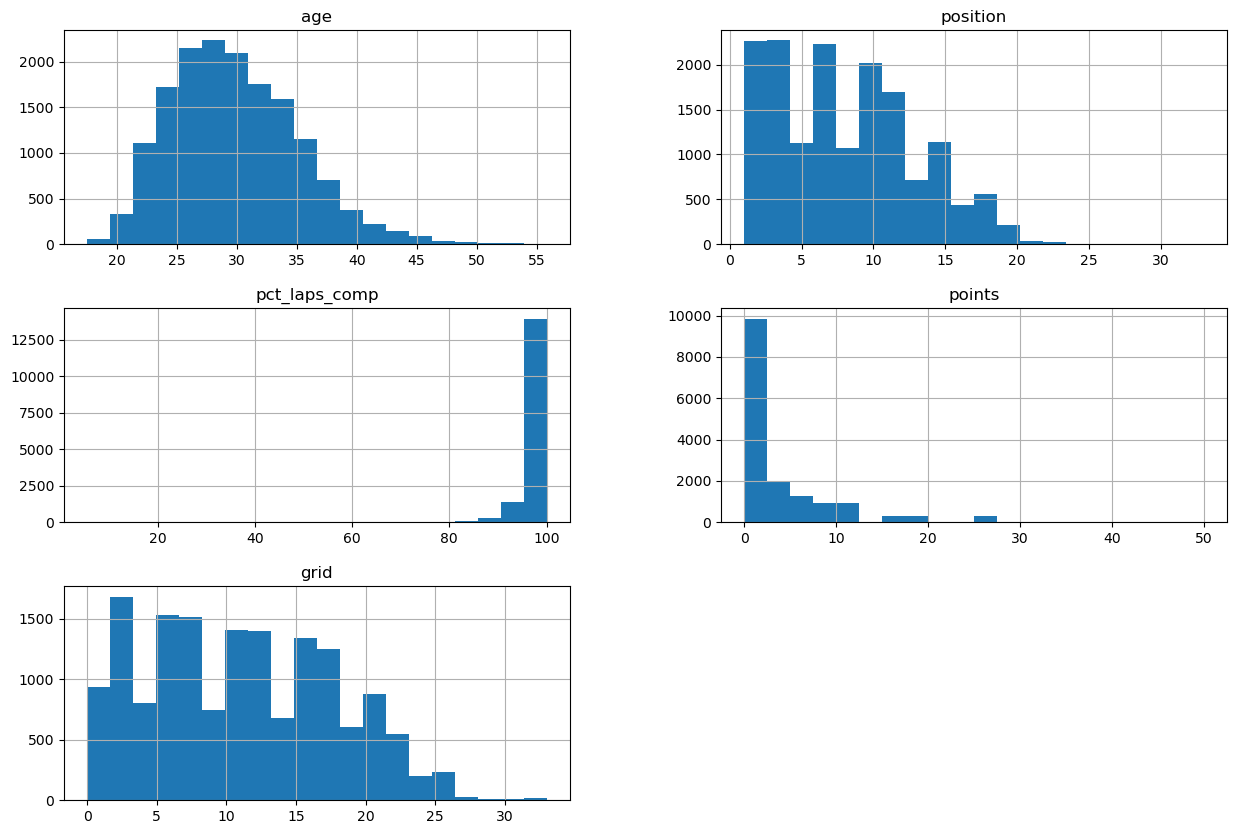

In [334]:
comp_df.hist(column = ["age", "position", "pct_laps_comp", "points", "grid"], 
                   bins = 20, 
                   figsize = (15, 10)
            )

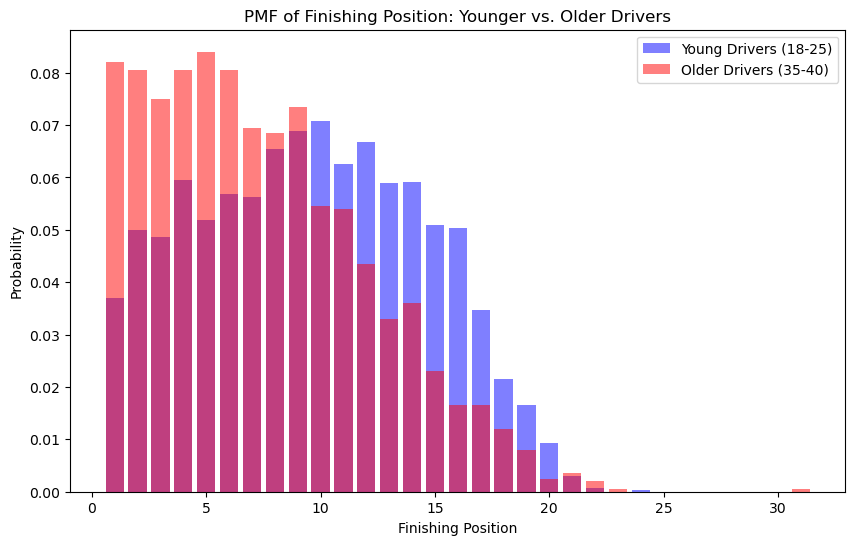

In [335]:
# Creating CDF for young an dold drivers to compare their chances of a finishing position
young = comp_df[comp_df["age_group"] == "18-25"]
old = comp_df[comp_df["age_group"] == "35-40"]

def pmf(data, var):
    value_counts = data[var].value_counts(normalize = True)
    value_counts = value_counts.sort_index()
    return value_counts

young_pmf = pmf(young, "position")
old_pmf = pmf(old, "position")

plt.figure(figsize = (10, 6))
plt.bar(young_pmf.index, young_pmf.values, alpha = 0.5, label = "Young Drivers (18-25)", color = "blue")
plt.bar(old_pmf.index, old_pmf.values, alpha = 0.5, label = "Older Drivers (35-40)", color = "red")

plt.title("PMF of Finishing Position: Younger vs. Older Drivers")
plt.xlabel("Finishing Position")
plt.ylabel("Probability")
plt.legend()
plt.show()

Text(0, 0.5, 'Cumulative Probability')

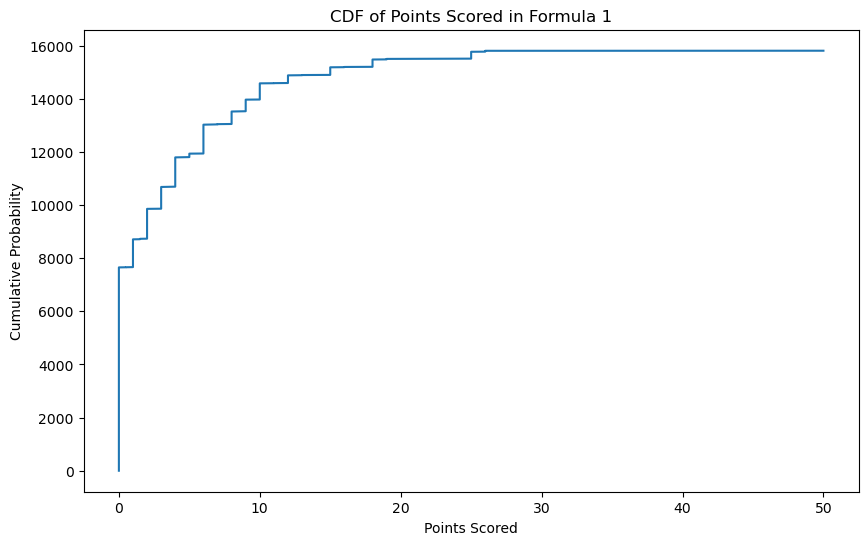

In [336]:
# Creating CDF for points
sorted_points = np.sort(comp_df["points"])

point_values = np.arange(1, len(sorted_points) + 1 / len(sorted_points))

plt.figure(figsize=(10, 6))
plt.plot(sorted_points, point_values)
plt.title("CDF of Points Scored in Formula 1")
plt.xlabel("Points Scored")
plt.ylabel("Cumulative Probability")

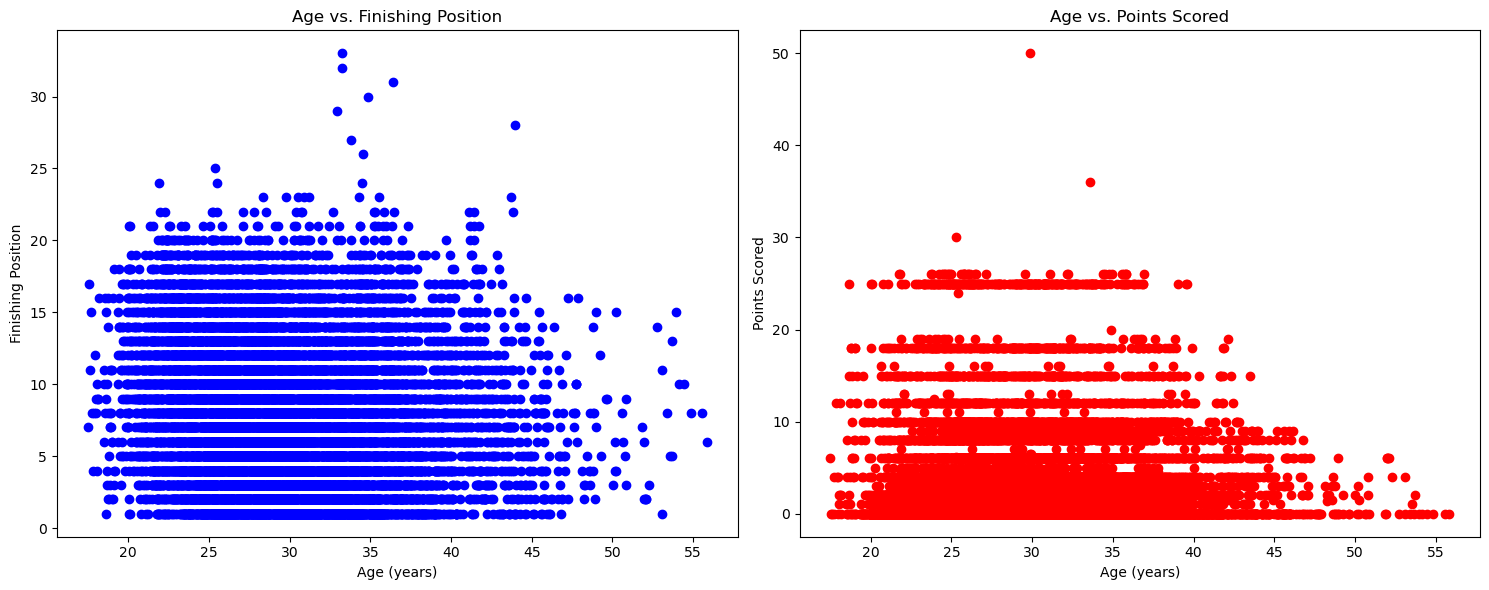

In [339]:
# Scatter Plots
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# Age vs. Finishing Position
axes[0].scatter(comp_df["age"], comp_df["position"], color = "blue")
axes[0].set_title("Age vs. Finishing Position")
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Finishing Position")

# Age vs. Points Scored
axes[1].scatter(comp_df["age"], comp_df["points"], color = "red")
axes[1].set_title("Age vs. Points Scored")
axes[1].set_xlabel("Age (years)")
axes[1].set_ylabel("Points Scored")

plt.tight_layout()
plt.show()

In [342]:
# Calculate correlation
corr_age_pos = comp_df["age"].corr(comp_df["position"])
corr_age_point = comp_df["age"].corr(comp_df["points"])
print(corr_age_pos, corr_age_point)

-0.1452438473446765 0.0011019821431649452


In [352]:
# Running OLS regression model (using statsmodels library to simplify process)
X = comp_df[["age", "position", "pct_laps_comp"]]
Y = comp_df["points"]

X = sm.add_constant(X)

model = sm.OLS(Y, X)
answer = model.fit()

print(answer.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     4030.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        04:04:47   Log-Likelihood:                -44107.
No. Observations:               15806   AIC:                         8.822e+04
Df Residuals:                   15802   BIC:                         8.825e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.1794      0.953      7.535